In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yaml
import matplotlib.dates as mdates
import os
import numpy as np
import yfinance as yf
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Adjust pandas settings to display all columns
pd.set_option('display.max_columns', None)


In [2]:
# Functions

def plot_seasonal_trends(pivot_dataset, chart_name, chart_title, poly_chart=None):
    # Paths to your Montserrat font files
    font_path = './assets/Montserrat/static/Montserrat-Regular.ttf'
    font_path_bold = './assets/Montserrat/static/Montserrat-Black.ttf'
    
    # Register the font properties
    prop = fm.FontProperties(fname=font_path)
    prop_black = fm.FontProperties(fname=font_path_bold)

    # Ensure plot_data is sorted by index (Week)
    plot_data = pivot_dataset.sort_index()

    # Create a numerical range for the x-axis based on the length of the DataFrame
    x_values = np.arange(len(plot_data)) + 1

    if chart_title == "US - Total Propane Stocks" or chart_title == "US - Propane Demand":
        # Full row: Reserve 50% of the 65% height
        plt.figure(figsize=(8.27, 2.8))  # Adjusted height for better visibility
    else:
        # 2x2 grid: Each chart takes 25% of the 65% height
        plt.figure(figsize=(4.14, 2.5))  # Adjusted dimensions for consistency

    # Plot the 5-Year Max/Min range as a shaded area
    plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

    # Colors
    fiveYear_avgColor = "black"
    fiveYear_2023Color = "#FFA500"
    fiveYear_2024Color = "#003366"
    
    if poly_chart:
        # Plot Polynomial 2023 and 2024
        plt.plot(plot_data.index, plot_data["poly_2023"], color=fiveYear_2023Color, label='Poly. 2023', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data["poly_2024"], color=fiveYear_2024Color, label='Poly. 2024', linewidth=1.5, alpha=0.7)
    else:
        # Plot 5-Year Average and actual values
        plt.plot(plot_data.index, plot_data['5YrAvg'], color=fiveYear_avgColor, linestyle='--', label='5-Year Average', linewidth=1)
        plt.plot(plot_data.index, plot_data[2023], color=fiveYear_2023Color, label='2023', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data[2024], color=fiveYear_2024Color, marker='o', label='2024', linewidth=2)

    # Format y-axis values
    def thousands(x, pos):
        """Format the y-axis values with a dot as the thousand separator."""
        return f'{x/1000:,.2f}'.replace(',', '.')
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
    
    y_label = "Thousand Barrels"
    
    if chart_title == "US - Total Propane Stocks" or chart_title == "US - Propane Demand":
        # Customize the plot for the main chart
        plt.title(chart_title, fontproperties=prop_black, size=20, pad=10)  # Larger title with size specified in title
        plt.xlabel("Week", fontproperties=prop, size=14)  # Larger x-label
        plt.ylabel(y_label, fontproperties=prop, size=14)  # Larger y-label
    
        # Place legend with regular font
        plt.legend(loc='lower left', prop=prop)

    else:
        # Customize the plot for smaller charts
        plt.title(chart_title, fontproperties=prop_black, size=10)  # Smaller title
        plt.xlabel("", fontproperties=prop, size=8)  # Smaller x-label
        plt.ylabel("", fontproperties=prop, size=8)  # Smaller y-label

    plt.grid(True, linestyle='--', alpha=0.6)  # Add consistent grid style
    plt.tight_layout()

    # Save the plot as a PNG file
    export_path = "../report/images/"
    export_file_name = chart_name.replace(" ", "_") + ".png"
    export_file_path = os.path.join(export_path, export_file_name)
    plt.savefig(export_file_path, bbox_inches='tight')

    # Show the plot
    plt.show()

# Export Pivot Data
def pivot_dataset(dataset, date_pos, data_position, exportFileName):
    
    # Select the columns by position
    df = dataset.iloc[:, [date_pos, data_position]].copy()
    
    # Rename the columns for easier access
    df.columns = ['Date', 'Data']
    
    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract week number, month, and year
    df['Week_Num'] = df['Date'].dt.isocalendar().week
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    
    # df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)
    
    # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
    pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
    
    # Sort the columns to have years starting from the newest
    pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)
    
    # Define the export path
    export_folder = "../data/processed/"
    export_file = export_folder + f"{exportFileName}.parquet"
    
    # Export the pivoted DataFrame to Parquet format
    pivoted_df.to_parquet(export_file)

    print("Success processed: " + dataset.columns[data_position])
    
    return pivoted_df
    
def calculate_5_year_metrics(df):
    """
    This function calculates the 5-year maximum, minimum, and average for each row
    excluding the first column in the provided DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame with at least 6 columns.

    Returns:
    pd.DataFrame: The DataFrame with 5YrMax, 5YrMin, and 5YrAvg columns added.
    """

    # Select the columns from the second to the sixth (excluding the first column)
    df = df.iloc[:,0:6]
    fiveYearsRange = df.iloc[:, 1:6]

    # Calculate the 5-year max, min, and average for each row
    df["5YrMax"] = fiveYearsRange.max(axis=1)
    df["5YrMin"] = fiveYearsRange.min(axis=1)
    df["5YrAvg"] = fiveYearsRange.mean(axis=1)

    return df

def poly_calc(data):
    
    # Ensure the length of x_date and y_num are the same
    x_date = data.index.values.reshape(-1, 1)

    # Current year
    y_num = data[2024].values

    # Filter out NaN values for fitting
    valid_idx = ~np.isnan(y_num)  # Boolean index for non-NaN values
    x_date_valid = x_date[valid_idx]
    y_num_valid = y_num[valid_idx]

    # Create polynomial features
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(x_date)

    # Fit the linear regression model using valid (non-NaN) data
    model = LinearRegression()
    model.fit(x_poly[valid_idx], y_num_valid)  # Fit only on valid data points

    # Make predictions using the model
    y_pred_2024 = model.predict(x_poly)

    # Mask predictions for NaN values
    y_pred_2024_with_na = np.where(np.isnan(y_num), np.nan, y_pred_2024)

    y_pred_2024_with_na 
    
    # Previous Year

    # Fill missing values in y_num with NaN for visualization purposes
    y_num = data[2023].values
    y_num_filled = y_num.copy()
    y_num_filled[np.isnan(y_num)] = np.nan  # Explicitly set NaN for missing values

    # Create polynomial features
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(x_date)

    # Fit the linear regression model (use filled values)
    model = LinearRegression()
    model.fit(x_poly[~np.isnan(y_num)], y_num[~np.isnan(y_num)])  # Fit only on valid data points

    # Make predictions
    y_pred_2023 = model.predict(x_poly)
    
    poly_dataset = pd.DataFrame([y_pred_2024_with_na, y_pred_2023], index=['poly_2024', 'poly_2023']).T
    poly_dataset.index = range(1, len(poly_dataset) + 1)
    
    return poly_dataset

def compute_summary_table(dataset, new_column_names):
    # Rename and select relevant columns
    summary_table = dataset
    summary_table.columns = new_column_names

    # Ensure Date column is a datetime
    summary_table["Date"] = pd.to_datetime(summary_table["Date"])
    summary_table = summary_table.sort_values(by="Date").reset_index(drop=True)

    # Add Week, Month, and Year columns
    summary_table["Week"] = summary_table["Date"].dt.isocalendar().week
    summary_table["Month"] = summary_table["Date"].dt.month
    summary_table["Year"] = summary_table["Date"].dt.year

    # Calculate 5-year average
    latest_row = summary_table.iloc[-1]
    five_year_avg = {}
    for col in new_column_names[1:]:
        five_year_data = summary_table[(summary_table["Week"] == latest_row["Week"]) &
                                       (summary_table["Year"] >= latest_row["Year"] - 5) &
                                       (summary_table["Year"] < latest_row["Year"])]
        five_year_avg[col] = five_year_data[col].mean() if not five_year_data.empty else np.nan

    # Compute metrics
    previous_row = summary_table.iloc[-2]
    mom_row = summary_table.iloc[-5] if len(summary_table) >= 5 else None

    # Extract YoY using week of the current year against the previous year
    yoy_rows = summary_table[(summary_table["Week"] == latest_row["Week"]) & (summary_table["Year"] == latest_row["Year"] - 1)]
    yoy_row = yoy_rows.iloc[0] if not yoy_rows.empty else None

    summary = []
    for col in new_column_names[1:]:
        last_value = latest_row[col]
        wow_pct = ((latest_row[col] - previous_row[col]) / previous_row[col]) * 100
        mom_pct = ((latest_row[col] - mom_row[col]) / mom_row[col] * 100) if mom_row is not None else np.nan
        yoy_pct = ((latest_row[col] - yoy_row[col]) / yoy_row[col] * 100) if yoy_row is not None else np.nan
        diff_5yr_avg = last_value - five_year_avg.get(col, np.nan)

        summary.append({
            "Region": col,
            "Last Value": last_value,
            "WoW (%)": wow_pct,
            "MoM (%)": mom_pct,
            "YoY (%)": yoy_pct,
            "Diff vs 5yr Avg": diff_5yr_avg
        })

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary).round(3)
    
    export_path="../report/tables/"
    export_file_name="summary_table.csv"
    
    # Ensure export directory exists
    os.makedirs(export_path, exist_ok=True)

    # Construct the full export path
    export_file_path = os.path.join(export_path, export_file_name)

    # Export DataFrame to CSV
    summary_df.to_csv(export_file_path, index=False)
    
    return summary_df

# Z-Score for 10 Years
def z_score_metric(pivot_subdataset):
    
    z_score_columns = []
    
    rowIndex = 1
    i = 0
    
    while rowIndex < 7:
        # Current Year
        z_score_dataset = pivot_subdataset.iloc[:,rowIndex:(12+i)]
        tenYearsRange = pivot_subdataset.iloc[:, rowIndex:(12+i)]
        
        # # Calculate the 10-year mean and std for each row
        z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
        z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
        
        # Calculate the 10-year mean and std for each row (e.g., each month)
        z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
        z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
        
        # Calculate the Z-score for the current year (assuming it's the first column)
        current_year_column = z_score_dataset.columns[0]  # First column of the dataset
        z_score_year = (
            (z_score_dataset[current_year_column] - z_score_dataset["TimeAverage"]) 
            / z_score_dataset["TimeStd"]
        )
        
        z_score_columns.append(z_score_year)
        
        rowIndex += 1
        i += 1
    
        # Create a DataFrame
    zScore_dataset = pd.DataFrame({
        f'{pivot_subdataset.columns[0]}': z_score_columns[0],
        f'{pivot_subdataset.columns[1]}': z_score_columns[1],
        f'{pivot_subdataset.columns[2]}': z_score_columns[2],
        f'{pivot_subdataset.columns[3]}': z_score_columns[3],
        f'{pivot_subdataset.columns[4]}': z_score_columns[4],
        f'{pivot_subdataset.columns[5]}': z_score_columns[5],
    })
    
    return zScore_dataset

def zscore_plot(pivot_dataset, chart_name, chart_title):
    # Paths to your Montserrat font files
    font_path = './assets/Montserrat/static/Montserrat-Regular.ttf'
    font_path_bold = './assets/Montserrat/static/Montserrat-Black.ttf'
    
    # Register the font properties
    prop = fm.FontProperties(fname=font_path)
    prop_bold = fm.FontProperties(fname=font_path_bold)

    # Prepare data
    plot_data = pivot_dataset.copy()
    
    # Get the list of columns
    years = plot_data.columns.tolist()
    
    # Identify current year, previous year, and previous previous year (assumes columns are sorted in descending order)
    current_year_col = years[0]
    previous_year_col = years[1]
    previous_previous_year_col = years[2]
    
    # Ensure plot_data is sorted by index
    plot_data = plot_data.sort_index()

    # Set up the figure size
    plt.figure(figsize=(8.27, 2.8))  # Adjusted height for better visibility

    # Colors
    color_previous_previous_year = "#800080"  # Purple
    color_previous_year = "#FFA500"          # Orange
    color_current_year = "#003366"           # Dark Blue
    
    # Plot the previous previous year's values
    plt.plot(
        plot_data.index, plot_data[previous_previous_year_col], 
        color=color_previous_previous_year, label=f'{previous_previous_year_col}', 
        linewidth=1.5, alpha=0.3
    )

    # Plot the previous year's values
    plt.plot(
        plot_data.index, plot_data[previous_year_col], 
        color=color_previous_year, label=f'{previous_year_col}', 
        linewidth=1.5, alpha=0.3
    )

    # Plot the current year's values
    plt.plot(
        plot_data.index, plot_data[current_year_col], 
        color=color_current_year, marker='o', label=f'{current_year_col}', 
        linewidth=2
    )

    # Customize the plot with Montserrat font
    plt.title(f"{chart_title}", fontsize=24, fontproperties=prop_bold)
    plt.xlabel("Week", fontsize=12, fontproperties=prop)
    plt.ylabel("Std. away from prior 10-yrs avg.", fontsize=11, fontproperties=prop)

    # Position the legend in the top-left corner with a highlighted background
    legend = plt.legend(
        loc='upper left', 
        bbox_to_anchor=(0, 1),  # Place legend outside the plot
        fontsize=10, 
        frameon=True,  # Enable frame
        prop=prop
    )
    legend.get_frame().set_facecolor('white')  # Set background color
    legend.get_frame().set_alpha(0.8)  # Make it semi-transparent
    legend.get_frame().set_edgecolor('black')  # Add a border color

    # Add grid
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save the plot as a PNG file
    # Ensure the folder exists
    export_path = f"../report/images/"
    os.makedirs(export_path, exist_ok=True)
    export_file_name = chart_name.replace(" ", "_") + ".png"
    export_file_path = os.path.join(export_path, export_file_name)
    plt.savefig(export_file_path, bbox_inches='tight')
    
    # plt.show()  # Displays the plot

    # plt.close()  # Closes the current figure
    
    return None

In [3]:
# Global Settings and Import Data

# Folder containing data files
raw_data_path = "../data/raw/"

# List all .xls files in the folder
propane_data_list = [file for file in os.listdir(raw_data_path) if file.endswith(".xls")]

# Importing All Databases
for file in propane_data_list:
    file_path = os.path.join(raw_data_path, file)
    
    # Propane Price
    propane_prices = pd.read_excel(file_path, sheet_name="Data 1", skiprows=2)
    
    # Propane Stocks
    propane_stocks = pd.read_excel(file_path, sheet_name="Data 2", skiprows=2)
    
    # Propane Days of Supply
    propane_daysofSupply = pd.read_excel(file_path, sheet_name="Data 3", skiprows=2)
    
    # Propane Production
    propane_production = pd.read_excel(file_path, sheet_name="Data 4", skiprows=2)
    
    # Propane Imports
    propane_imports = pd.read_excel(file_path, sheet_name="Data 5", skiprows=2)
    
    # Propane Exports
    propane_exports = pd.read_excel(file_path, sheet_name="Data 6", skiprows=2)
    
    # Propane Supplied
    propane_supplied = pd.read_excel(file_path, sheet_name="Data 7", skiprows=2)



Success processed: Weekly U.S. Propane and Propylene Ending Stocks Excluding Propylene at Terminal (Thousand Barrels)


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

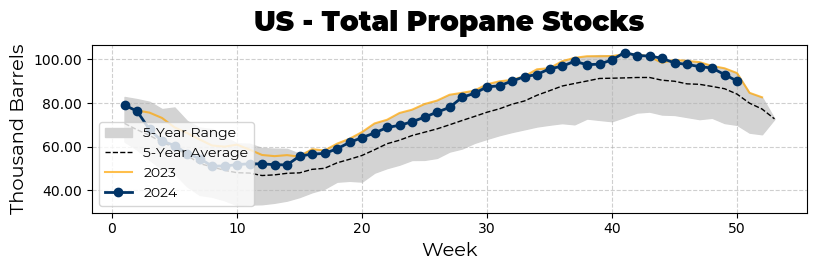

Success processed: Weekly East Coast (PADD 1) Propane and Propylene Ending Stocks Excluding Propylene at Terminal (Thousand Barrels)


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

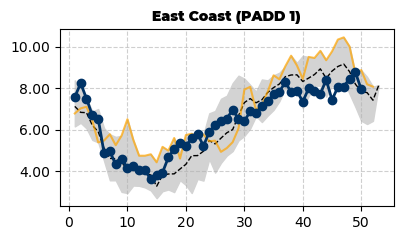

Success processed: Weekly Midwest (PADD 2) Propane and Propylene Ending Stocks Excluding Propylene at Terminal (Thousand Barrels)


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

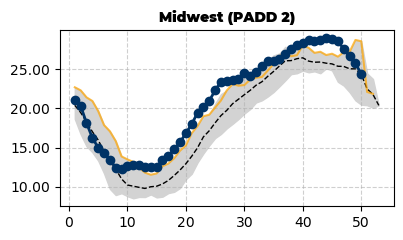

Success processed: Weekly Gulf Coast (PADD 3) Propane and Propylene Ending Stocks Excluding Propylene at Terminal (Thousand Barrels)


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

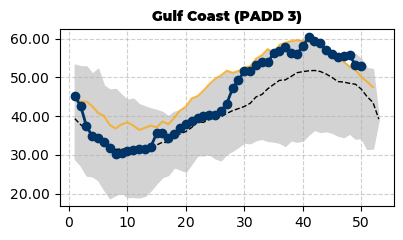

Success processed: Weekly PADD 4 and PADD 5 Propane and Propylene Ending Stocks Excluding Propylene at Terminal (Thousand Barrels)


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

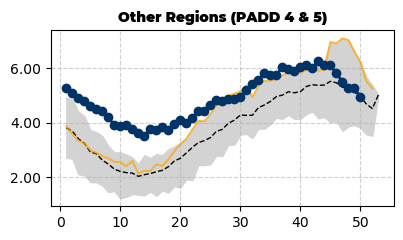

In [4]:
# Chart Stocks

## US Stocks
data_reference = "us_propane_stocks"
data_name = "US - Total Propane Stocks"
pivot_dataset(propane_stocks, 0, 1, data_reference)

us_propane_stocks = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
us_propane_stocks = calculate_5_year_metrics(us_propane_stocks)
plot_seasonal_trends(us_propane_stocks, data_reference , data_name, poly_chart=None)

## PADD 1
data_reference = "padd1_propane_stocks"
data_name = "East Coast (PADD 1)"
pivot_dataset(propane_stocks, 0, 2, data_reference)

padd1_propane_stocks = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
padd1_propane_stocks = calculate_5_year_metrics(padd1_propane_stocks)
plot_seasonal_trends(padd1_propane_stocks, data_reference , data_name, poly_chart=None)

## PADD 2
data_reference = "padd2_propane_stocks"
data_name = "Midwest (PADD 2)"
pivot_dataset(propane_stocks, 0, 6, data_reference)

padd2_propane_stocks = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
padd2_propane_stocks = calculate_5_year_metrics(padd2_propane_stocks)
plot_seasonal_trends(padd2_propane_stocks, data_reference , data_name, poly_chart=None)

## PADD 3
data_reference = "padd3_propane_stocks"
data_name = "Gulf Coast (PADD 3)"
pivot_dataset(propane_stocks, 0, 7, data_reference)

padd3_propane_stocks = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
padd3_propane_stocks = calculate_5_year_metrics(padd3_propane_stocks)
plot_seasonal_trends(padd3_propane_stocks, data_reference , data_name, poly_chart=None)

## PADD 4 and 5
data_reference = "padd4n5_propane_stocks"
data_name = "Other Regions (PADD 4 & 5)"
pivot_dataset(propane_stocks, 0, 9, data_reference)

padd4n5_propane_stocks = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
padd4n5_propane_stocks = calculate_5_year_metrics(padd4n5_propane_stocks)
plot_seasonal_trends(padd4n5_propane_stocks, data_reference , data_name, poly_chart=None)



In [5]:
# Summary Table
summary_table = propane_stocks.iloc[:, [0, 1, 2, 6, 7, 9]].sort_values(by="Date").reset_index(drop=True)
columns_name = ["Date", "Total Stocks", "PADD 1", "PADD 2", "PADD 3", "PADD 4 & 5"]

compute_summary_table(summary_table, columns_name)

,Region,Last Value,WoW (%),MoM (%),YoY (%),Diff vs 5yr Avg
0,Total Stocks,90099.0,-3.175,-7.785,-3.874,5986.2
1,PADD 1,7938.0,-9.332,-1.391,-10.467,104.0
2,PADD 2,24344.0,-5.464,-14.955,-14.678,21.2
3,PADD 3,52876.0,-0.741,-4.231,5.518,5878.8
4,PADD 4 & 5,4941.0,-6.367,-15.059,-20.588,-18.4


Success processed: Weekly U.S. Product Supplied of Propane and Propylene  (Thousand Barrels per Day)


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

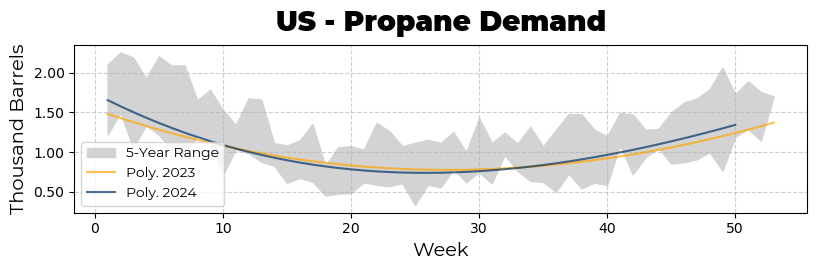

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:272: SettingWithCopyWarning: 
A value is trying to be set 

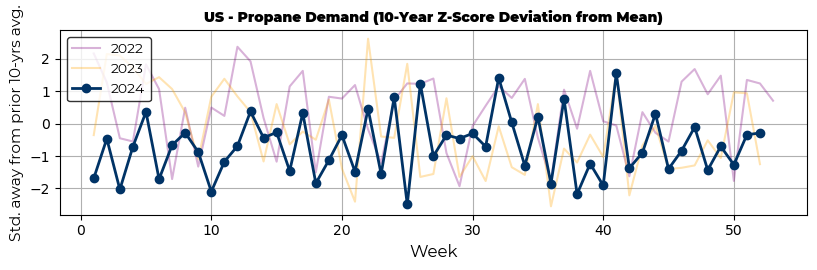

In [6]:
# Chart Demand
data_reference = "us_propane_demand"
data_name = "US - Propane Demand"
propane_demand_pivot = pivot_dataset(propane_supplied, 0, 1, data_reference)

us_propane_demand = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
us_propane_demand = calculate_5_year_metrics(us_propane_demand)
poly_data = poly_calc(us_propane_demand)

# Join the DataFrames on index
us_propane_demand = us_propane_demand.join(poly_data)
plot_seasonal_trends(us_propane_demand, data_reference , data_name, poly_chart=True)

# Z-Score
data_reference = "us_propane_demand_zscore"
data_name = "US - Propane Demand (10-Year Z-Score Deviation from Mean)"
z_score_dataset = z_score_metric(propane_demand_pivot)
zscore_plot(z_score_dataset, data_reference, data_name)

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMax"] = fiveYearsRange.max(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["5YrMin"] = fiveYearsRange.min(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Success processed: Weekly U.S. Exports of Propane (Thousand Barrels per Day)


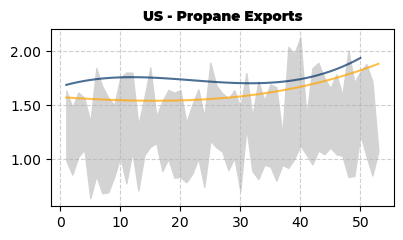

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_26405/3338572098.py:272: SettingWithCopyWarning: 
A value is trying to be set 

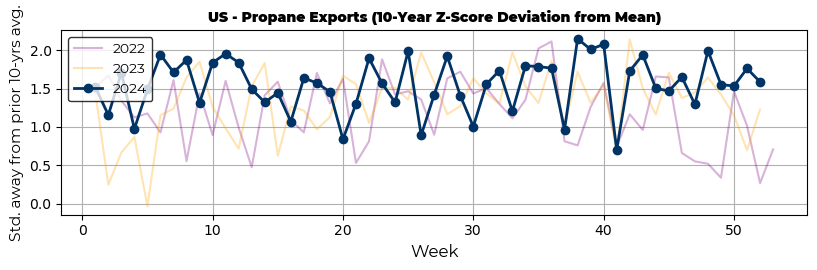

In [7]:
# Chart Exports
data_reference = "us_propane_exports"
data_name = "US - Propane Exports"
propane_exports_pivot = pivot_dataset(propane_exports, 0, 1, data_reference)

us_propane_demand = pd.read_parquet(f"../data/processed/{data_reference}.parquet", engine='pyarrow')  # or engine='fastparquet'
us_propane_demand = calculate_5_year_metrics(us_propane_demand)
poly_data = poly_calc(us_propane_demand)

# Join the DataFrames on index
us_propane_demand = us_propane_demand.join(poly_data)
plot_seasonal_trends(us_propane_demand, data_reference , data_name, poly_chart=True)

# Z-Score
data_reference = "us_propane_exports_zscore"
data_name = "US - Propane Exports (10-Year Z-Score Deviation from Mean)"
z_score_dataset = z_score_metric(propane_exports_pivot)
zscore_plot(z_score_dataset, data_reference, data_name)